# Earnest Sequence Project

## Requirements (by Vishnu)

We would like to use Earnest Database to find a correlation between Invoice Ids and Day, Month and Year over a period of time for 40 companies. Here are the elements:
 
1. Create a View for each company from Earnest database, that does the following:
    
    a. Eliminates time from the date-filed (timestamp is not reliable)
    
    b. Creates additional fields for Yr, Qtr, Month, Week#, Day

2. For each company create a scatter plot of order number by day
    
    a. Eliminate any characters
    
    b. Identify if any of the digits are denoting either year/qtr/month/week and separate them
    
    c. Identify any unusual bumps and explain them (eliminate these data points from the sequence, if necessary)

3. Finally, create a multi-variate linear regression (excel is good enough) for the company order numbers. Given a date we should be able to identify the order number range.

4. Show the t-stat and df-stat (all other output of regression and based on these and standard errors, outline the confidence level of order number prediction based on date

## Suggested Approach for the Solution

- We will follow these steps to arrive at the best solution:

    a. Step 1: Looking at the data
    
    b. Step 2: Clean and transform the data to prepare for use by scikit learn toolkit. 
    
    c. Step 2: Visualize the relationship between the features and the target.
    
    d. Step 3: Attempt multiple algorithms to find the best fit.
    
    
- We will attempt Multivariate Linear Regression first. We shall calculate the metrics and evaluate the model based on those measurements.

- Next, we will attempt Multivariate Polinomial Regression. We shall transform the feature matrix into higher degress of polynomials and apply various linear regression techniques like Ordinary Least Squares, Ridge, Lasso, Elastic Net, Least Angle Regression, Orthogonal Matching Pursuit, Bayesian, Automatice Relevance Determination, etc.


## Step 1: Looking at the data

In [235]:
import pandas as pd

# read CSV file
data = pd.read_csv('data/OrderNumSeq.csv')
data.head()

,invoice_id,order_date
0,P-102-7259-9819,01/10/11
1,P-103-9411-9011,09/10/11
2,P-103-3485-7262,25/10/11
3,P-103-5837-4851,02/11/11
4,P-103-8009-1414,08/11/11


In [236]:
data.shape

(25893, 2)

In [237]:
data.tail()

,invoice_id,order_date
25888,P-144-8565-4736,27/06/16
25889,P-144-8585-4733,27/06/16
25890,P-144-8605-4766,27/06/16
25891,P-144-8605-4788,27/06/16
25892,P-144-8615-4702,27/06/16


## Step 2: Clean and transform the data to prepare for use by scikit learn toolkit.

In [238]:
data['invoice_id'] = data['invoice_id'].str.replace('-', '').str[1:].astype(int)
data.head()

,invoice_id,order_date
0,10272599819,01/10/11
1,10394119011,09/10/11
2,10334857262,25/10/11
3,10358374851,02/11/11
4,10380091414,08/11/11


In [239]:
import datetime as dt
data['order_date'] = data['order_date'].apply(lambda x: dt.datetime.strptime(x, "%d/%m/%y"))
data.head()

,invoice_id,order_date
0,10272599819,2011-10-01
1,10394119011,2011-10-09
2,10334857262,2011-10-25
3,10358374851,2011-11-02
4,10380091414,2011-11-08


In [240]:
data['year'] = data['order_date'].apply(lambda x: x.year)
data['month'] = data['order_date'].apply(lambda x: x.month)
data['day'] = data['order_date'].apply(lambda x: x.day)

In [241]:
data.head()

,invoice_id,order_date,year,month,day
0,10272599819,2011-10-01,2011,10,1
1,10394119011,2011-10-09,2011,10,9
2,10334857262,2011-10-25,2011,10,25
3,10358374851,2011-11-02,2011,11,2
4,10380091414,2011-11-08,2011,11,8


## Step 3: Visualize the relationship between the features and the target

In [242]:
# conventional way to import seaborn
import seaborn as sns

# allow plots to appear within the notebook
%matplotlib inline

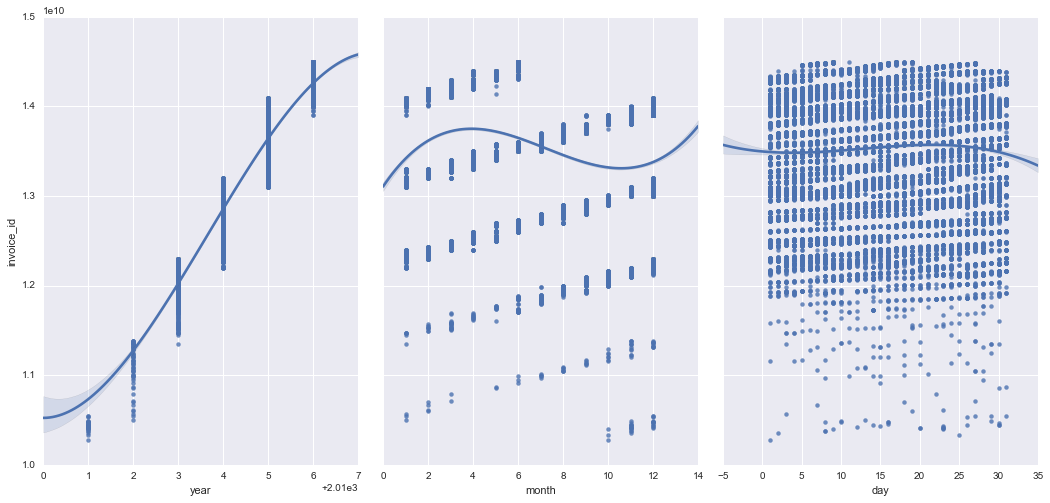

In [327]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(data, x_vars=['year', 'month', 'day'], y_vars='invoice_id', 
             size=7, aspect=0.7, kind='reg', plot_kws=dict(order=3))

## Step 4: Attempt an algorithm.

## Linear regression

**Pros:** fast, no tuning required, highly interpretable, well-understood

**Cons:** unlikely to produce the best predictive accuracy (presumes a linear relationship between the features and response)

### Form of linear regression

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$

- $y$ is the response
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for $x_1$ (the first feature)
- $\beta_n$ is the coefficient for $x_n$ (the nth feature)

In this case:

$y = \beta_0 + \beta_1 \times year + \beta_2 \times month + \beta_3 \times day$

The $\beta$ values are called the **model coefficients**. These values are "learned" during the model fitting step using the "least squares" criterion. Then, the fitted model can be used to make predictions!


## Preparing X and y using pandas

- We shall use scikit-learn toolkit to run the linear regression.
- X (feature matrix) is a pandas DataFrame and y (response vector) is a pandas Series!

In [291]:
# create a Python list of feature names
feature_cols = ['year', 'month', 'day']

# use the list to select a subset of the original DataFrame
X = data[feature_cols]

# print the first 5 rows
X.head()

,year,month,day
0,2011,10,1
1,2011,10,9
2,2011,10,25
3,2011,11,2
4,2011,11,8


In [292]:
# select a Series from the DataFrame
y = data['invoice_id']
y.head()

0    10272599819
1    10394119011
2    10334857262
3    10358374851
4    10380091414
Name: invoice_id, dtype: int64

## Splitting X and y into training and testing sets

In [293]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [294]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Interpreting model coefficients

In [295]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

-1.75222486356e+12
[  8.76078405e+08   7.25455999e+07   2.41598850e+06]


In [296]:
# pair the feature names with the coefficients
zip(feature_cols, linreg.coef_)

[('year', 876078404.87677395),
 ('month', 72545599.928613022),
 ('day', 2415988.4990311279)]

$$y = -1752224863560 + 876078405 \times year + 72545600 \times month + 2415989 \times day$$

How do we interpret the **year coefficient** (876078405)?

- For a given month and day, **a "unit" increase in year** is associated with a **876078405 "units" increase in invoice id**.

Important notes:

- This is a statement of **association**, not **causation**.

### Making predictions

In [297]:
# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [298]:
print('Actual:   ', y_test[0:4].values)
print('Predicted:', y_pred[0:4].astype(int))

('Actual:   ', array([14191359744, 13209360279, 12236534644, 13908742787]))
('Predicted:', array([14157107568, 13256869279, 12227752480, 13936355551]))


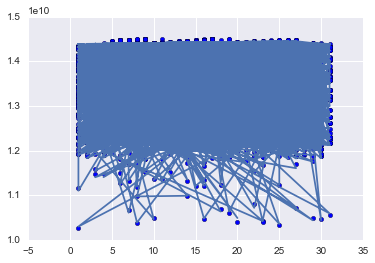

In [303]:
plt.scatter(X_test['day'], y_test)
plt.plot(X_test['day'], y_pred)

## Model evaluation metrics for regression

We need an **evaluation metric** in order to compare our predictions with the actual values!

Let's calculate **three common evaluation metrics** for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

### Computing the MAE, MSE and RMSE for our Invoice ID predictions

In [252]:
import numpy as np
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('MAE:', 33483845.797657616)
('MSE:', 1676064882080969.0)
('RMSE:', 40939771.397517219)


## Feature selection

Does **day** "belong" in our model? In other words, does it improve the quality of our predictions?

Let's **remove it** from the model and check the RMSE!

In [253]:
# create a Python list of feature names
feature_cols = ['year', 'month']

# use the list to select a subset of the original DataFrame
X = data[feature_cols]

# select a Series from the DataFrame
y = data['invoice_id']

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

print('Actual:   ', y_test[0:4].values)
print('Predicted:', y_pred[0:4].astype(int))

# compute the metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Actual:   ', array([14191359744, 13209360279, 12236534644, 13908742787]))
('Predicted:', array([14132017149, 13256012287, 12228607435, 13908156673]))
('MAE:', 37883056.944218352)
('MSE:', 2150270477933247.0)
('RMSE:', 46371009.024316549)


## Feature selection

Does **month** "belong" in our model? In other words, does it improve the quality of our predictions?

Let's **remove it** from the model and check the RMSE!

In [254]:
# create a Python list of feature names
feature_cols = ['year', 'day']

# use the list to select a subset of the original DataFrame
X = data[feature_cols]

# select a Series from the DataFrame
y = data['invoice_id']

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

print('Actual:   ', y_test[0:4].values)
print('Predicted:', y_pred[0:4].astype(int))

# compute the metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Actual:   ', array([14191359744, 13209360279, 12236534644, 13908742787]))
('Predicted:', array([14333127714, 13589643206, 12142194264, 13612523250]))
('MAE:', 196547048.15062144)
('MSE:', 56643809311522448.0)
('RMSE:', 237999599.39361757)


## Feature selection

Does **year** "belong" in our model? In other words, does it improve the quality of our predictions?

Let's **remove it** from the model and check the RMSE!

In [255]:
# create a Python list of feature names
feature_cols = ['month', 'day']

# use the list to select a subset of the original DataFrame
X = data[feature_cols]

# select a Series from the DataFrame
y = data['invoice_id']

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

print('Actual:   ', y_test[0:4].values)
print('Predicted:', y_pred[0:4].astype(int))

# compute the metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Actual:   ', array([14191359744, 13209360279, 12236534644, 13908742787]))
('Predicted:', array([13703376430, 13681185069, 13364298301, 13422394698]))
('MAE:', 573273200.78198826)
('MSE:', 4.6701978936537613e+17)
('RMSE:', 683388461.53953767)


## Feature selection

Do **month** and **day** "belong" in our model? In other words, does it improve the quality of our predictions?

Let's **remove it** from the model and check the RMSE!

In [256]:
# create a Python list of feature names
feature_cols = ['year']

# use the list to select a subset of the original DataFrame
X = data[feature_cols]

# select a Series from the DataFrame
y = data['invoice_id']

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

print('Actual:   ', y_test[0:4].values)
print('Predicted:', y_pred[0:4].astype(int))

# compute the metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Actual:   ', array([14191359744, 13209360279, 12236534644, 13908742787]))
('Predicted:', array([14311345200, 13588569092, 12143016878, 13588569092]))
('MAE:', 196143590.9817726)
('MSE:', 56760699759987400.0)
('RMSE:', 238245041.41741839)


## Conclusion

Linear Regression doesn't appear to be the right model for this prediciton. The errors are too high. **Day** doesn't appear to influence the target that much as removing that feature did not have any affect on the predictions.

## Polynomial regression

One common pattern within machine learning is to use linear models trained on nonlinear functions of the data. This approach maintains the generally fast performance of linear methods, while allowing them to fit a much wider range of data.

For example, a simple linear regression can be extended by constructing polynomial features from the coefficients. In the standard linear regression case, you might have a model that looks like this for two-dimensional data:

$y = \beta_0 + \beta_1x_1 + \beta_2x_2$

If we want to fit a paraboloid to the data instead of a plane, we can combine the features in second-order polynomials, so that the model looks like this:

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_1x_2 + \beta_4x_1^2 + \beta_5x_2^2   $

The PolynomialFeatures preprocessor transforms an input data matrix into a new data matrix of a given degree.

In [304]:
# import model
from sklearn.preprocessing import PolynomialFeatures

# create a Python list of feature names
feature_cols = ['year', 'month', 'day']

# use the list to select a subset of the original DataFrame
X = data[feature_cols]

# transform to a 2 degree polynomial
poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(X)

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)
print(linreg)

# print the alpha, intercept and coefficients
print('intercept: ', linreg.intercept_)
print('coef: ', linreg.coef_.astype(int))

# make predictions on the testing set
y_pred = linreg.predict(X_test)

print('Actual:   ', y_test[0:4].values)
print('Predicted:', y_pred[0:4].astype(int))

# compute the metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
('intercept: ', -22587672254743232.0)
('coef: ', array([             0, 33625083994802,  4980346374465,   236554183953,
         -16685729019,    -4943114931,     -233635696,      205728432,
           -355124314,       -6170489,        2760051,        1226558,
                57687,        -102072,         176201,           3124,
               -15713,          20993,          -3448,          -2370]))
('Actual:   ', array([14191359744, 13209360279, 12236534644, 13908742787]))
('Predicted:', array([14150389716, 13254626576, 12246513460, 13941454412]))
('MAE:', 32925034.0909793)
('MSE:', 1622447209104426.0)
('RMSE:', 40279612.822176255)


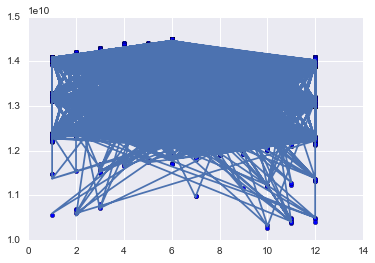

In [324]:
plt.scatter(X_test[:,2], y_test)
plt.plot(X_test[:,2], y_pred)

In [328]:
# import model
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures

# create a Python list of feature names
feature_cols = ['year', 'month', 'day']

# use the list to select a subset of the original DataFrame
X = data[feature_cols]

# transform to a 2 degree polynomial
poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X)

# select a Series from the DataFrame
y = data['invoice_id']

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# instantiate
ridgereg = RidgeCV(alphas=[0.001, 0.1, 1.0, 10])

# fit the model to the training data (learn the coefficients)
ridgereg.fit(X_train, y_train)

# print the alpha, intercept and coefficients
print('alpha: ', ridgereg.alpha_)
print('intercept: ', ridgereg.intercept_)
print('coef: ', ridgereg.coef_.astype(int))

# make predictions on the testing set
y_pred = ridgereg.predict(X_test)

print('Actual:   ', y_test[0:4].values)
print('Predicted:', y_pred[0:4].astype(int))

# compute the metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('alpha: ', 0.001)
('intercept: ', 5374241558625.0898)
('coef: ', array([          0, -3824463721,  1174102476,  -100628765,      575575,
             -4992,       69992,      -54748,       66115,      -14076]))
('Actual:   ', array([14191359744, 13209360279, 12236534644, 13908742787]))
('Predicted:', array([ 6784532457,  7887578588, 22500274379, 18812884198]))
('MAE:', 4763360136.9762297)
('MSE:', 2.919573212650265e+19)
('RMSE:', 5403307517.2992563)


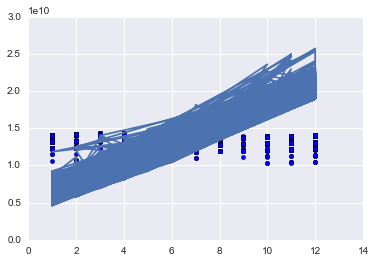

In [329]:
plt.scatter(X_test[:,2], y_test)
plt.plot(X_test[:,2], y_pred)